## Librerias

In [4]:
library(dplyr)

library(FactoClass)
library(FactoMineR)
library(factoextra)
library(plotly)
library(knitr)
library(DT)
library(DBI)

## Parametros

In [5]:
# Proyecto de GCP
project <- "co-keralty-costomedico"

# Query para traer la data de diabetes
query <- "SELECT * FROM Diabetes_avicena_survival.diabetes_final"

# Configuracion de la conexion a BigQuery
con <- dbConnect(bigrquery::bigquery(),
                 project = project,
                 dataset = "Diabetes_avicena_survival",
                 location = "us-east1")

# Columnas cualitativas
variables_numericas <- c("year",
                         "month",
                         "edad",
                         "peso",
                         "talla",
                         "HDL",
                         "LDL",
                         "trigliceridos",
                         "perimetro_abdominal",
                         "time_to_event")

# Columnas categoricas
variables_factores <- c("genero_paciente",
                        "raza_paciente",
                        "nivel_academico_paciente",
                        "ant_cardio",
                        "med_hipertension",
                        "ant_familiar_dm",
                        "hace_ejercicio",
                        "diabetes")

## Carga de datos

In [10]:
# Traer la data desde BigQuery
data <- read.table("datas_no_outliers.csv",
                   sep = "|", header = TRUE)

In [11]:
# Realizar cambios en cada una de las columnas de la data
data <- data %>% mutate(across(all_of(variables_factores), as.factor))
data <- data %>% mutate(across(all_of(variables_numericas), as.numeric))

# Vista de los cambios realizados
str(data)

'data.frame':	8020 obs. of  20 variables:
 $ numero_identificacion_paciente: num  1.01e+09 2.62e+07 9.34e+07 4.35e+07 9.44e+07 ...
 $ year                          : num  2022 2022 2022 2024 2024 ...
 $ month                         : num  8 8 8 1 1 5 5 9 2 2 ...
 $ fecha                         : chr  "2022-08-01" "2022-08-01" "2022-08-01" "2024-01-01" ...
 $ edad                          : num  19 70 47 56 50 44 45 43 31 55 ...
 $ peso                          : num  56 82 85.2 56 91 81.2 79 85.9 52.2 85.5 ...
 $ talla                         : num  1.61 1.59 1.6 1.55 1.75 1.63 1.7 1.69 1.57 1.71 ...
 $ HDL                           : num  56 45.3 44 51 38 45.5 46 30 33.4 26 ...
 $ LDL                           : num  99 158 174 143 151 ...
 $ trigliceridos                 : num  95 238 90.1 254.7 211 ...
 $ perimetro_abdominal           : num  75 96 103 74.5 95 ...
 $ genero_paciente               : Factor w/ 2 levels "Femenino","Masculino": 1 1 2 1 2 2 2 1 1 2 ...
 $ raza_paciente 

## ACP

In [16]:
vars_ilustrativas <- c()

In [15]:
data_to_acp <- data[, 5:11]
head(data_to_acp)

,edad,peso,talla,HDL,LDL,trigliceridos,perimetro_abdominal
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,19,56.0,1.61,56.0,99.00,95.00,75.0
2,70,82.0,1.59,45.3,158.00,238.00,96.0
3,47,85.2,1.60,44.0,174.06,90.13,103.0
4,56,56.0,1.55,51.0,143.40,254.70,74.5
5,50,91.0,1.75,38.0,150.80,211.00,95.0
6,44,81.2,1.63,45.5,151.80,90.10,101.5


In [17]:
help(dudi.pca)

dudi.pca                 package:ade4                  R Documentation

_P_r_i_n_c_i_p_a_l _C_o_m_p_o_n_e_n_t _A_n_a_l_y_s_i_s

_D_e_s_c_r_i_p_t_i_o_n:

     'dudi.pca' performs a principal component analysis of a data frame
     and returns the results as objects of class 'pca' and 'dudi'.

_U_s_a_g_e:

     dudi.pca(df, row.w = rep(1, nrow(df))/nrow(df), 
         col.w = rep(1, ncol(df)), center = TRUE, scale = TRUE, 
         scannf = TRUE, nf = 2)
     
_A_r_g_u_m_e_n_t_s:

      df: a data frame with n rows (individuals) and p columns (numeric
          variables)

   row.w: an optional row weights (by default, uniform row weights)

   col.w: an optional column weights (by default, unit column weights)

  center: a logical or numeric value, centring option
          if TRUE, centring by the mean
          if FALSE no centring
          if a numeric vector, its length must be equal to the number
          of columns of the data fr

In [18]:
acp <- dudi.pca(data_to_acp, scannf = FALSE, nf = 7)

[1] "Medias de las variables"
               edad                peso               talla                 HDL 
          59.072444           73.283679            1.610958           47.766259 
                LDL       trigliceridos perimetro_abdominal 
         112.084447          143.239911           93.316782 
[1] "Desviacion estandar de las variables"
               edad                peso               talla                 HDL 
              15.16               14.19                0.09               10.89 
                LDL       trigliceridos perimetro_abdominal 
              36.94               58.93               11.42 
[1] "Valores propios"


Inertia information:
Call: inertia.dudi(x = acp)

Decomposition of total inertia:
    inertia     cum  cum(%)
Ax1  2.3286   2.329   33.27
Ax2  1.2137   3.542   50.61
Ax3  1.1703   4.713   67.32
Ax4  0.9417   5.654   80.78
Ax5  0.6723   6.327   90.38
Ax6  0.5079   6.835   97.64
Ax7  0.1654   7.000  100.00

[1] "Vectores Propios"
                       CS1    CS2    CS3    CS4    CS5    CS6    CS7
edad                 0.207  0.528  0.452  0.331 -0.559  0.055  0.222
peso                -0.584 -0.180  0.099  0.238  0.123 -0.048  0.737
talla               -0.409 -0.393  0.075 -0.196 -0.709 -0.249 -0.266
HDL                  0.386 -0.376  0.091  0.513  0.092 -0.655 -0.022
LDL                  0.017 -0.060 -0.734  0.520 -0.306  0.307  0.000
trigliceridos       -0.260  0.606 -0.399 -0.097  0.027 -0.629 -0.019
perimetro_abdominal -0.481  0.148  0.273  0.502  0.262  0.119 -0.580
[1] "Histograma de los valores propios"


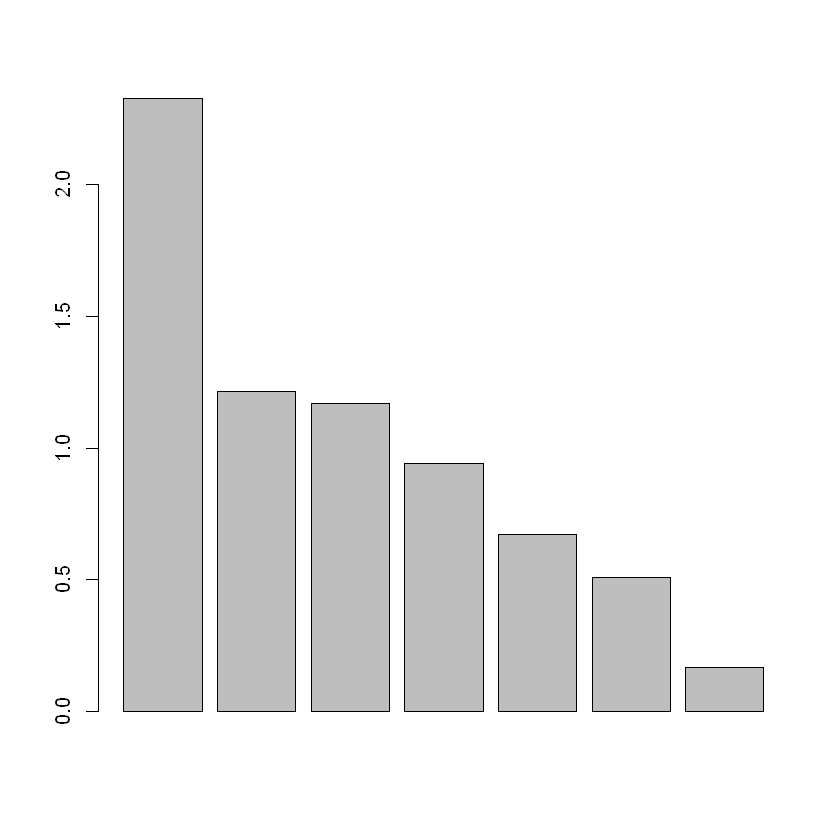

In [19]:
print("Medias de las variables")
print(acp$cent)

print("Desviacion estandar de las variables")
print(round(acp$norm, 2))

print("Valores propios")
inertia(acp)

print("Vectores Propios")
print(round(acp$c1, 3))

print("Histograma de los valores propios")
barplot(acp$eig)

[1] "Histograma del porcentaje de variacion"


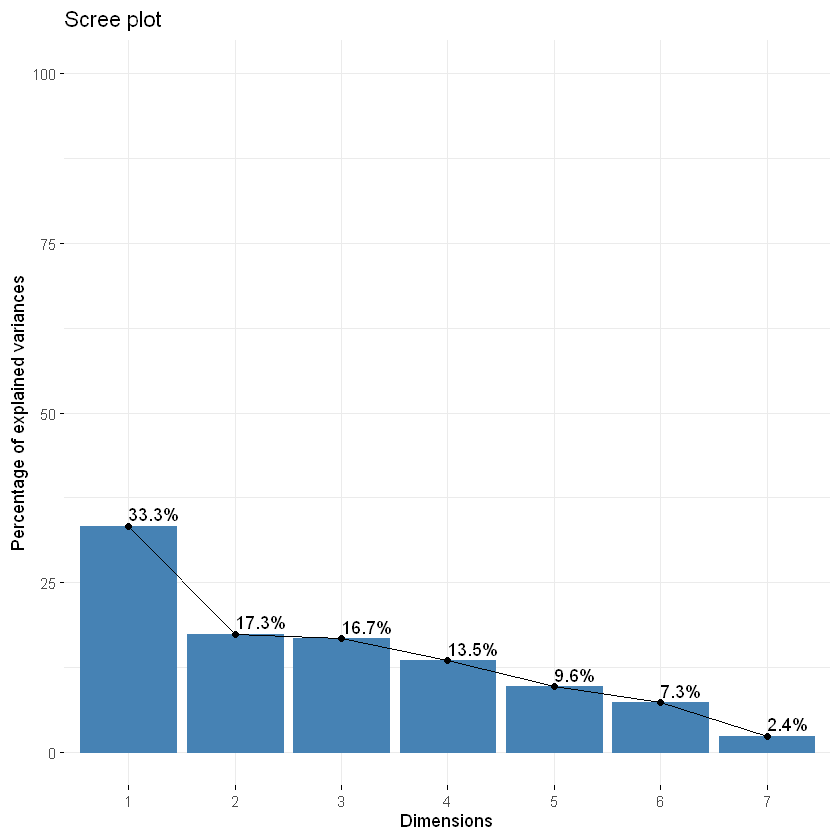

In [21]:
print("Histograma del porcentaje de variacion")
fviz_screeplot(acp, addlabels = TRUE, ylim = c(0, 100))

In [22]:
print("Entendimiento de los valores")
inertia(acp, , TRUE)

[1] "Entendimiento de los valores"


Inertia information:
Call: inertia.dudi(x = acp, col.inertia = TRUE)

Decomposition of total inertia:
    inertia     cum  cum(%)
Ax1  2.3286   2.329   33.27
Ax2  1.2137   3.542   50.61
Ax3  1.1703   4.713   67.32
Ax4  0.9417   5.654   80.78
Ax5  0.6723   6.327   90.38
Ax6  0.5079   6.835   97.64
Ax7  0.1654   7.000  100.00

Column contributions (%):
               edad                peso               talla                 HDL 
              14.29               14.29               14.29               14.29 
                LDL       trigliceridos perimetro_abdominal 
              14.29               14.29               14.29 

Column absolute contributions (%):
                       Axis1   Axis2   Axis3   Axis4    Axis5   Axis6     Axis7
edad                 4.26833 27.9171 20.4282 10.9705 31.19583  0.3015 4.919e+00
peso                34.13675  3.2348  0.9744  5.6695  1.50153  0.2330 5.425e+01
talla               16.72023 15.4415  0.5579  3.8296 50.19788  6.2030 7.050e+00
HDL    

[1] "Correlaciones de las variables suplementarias"


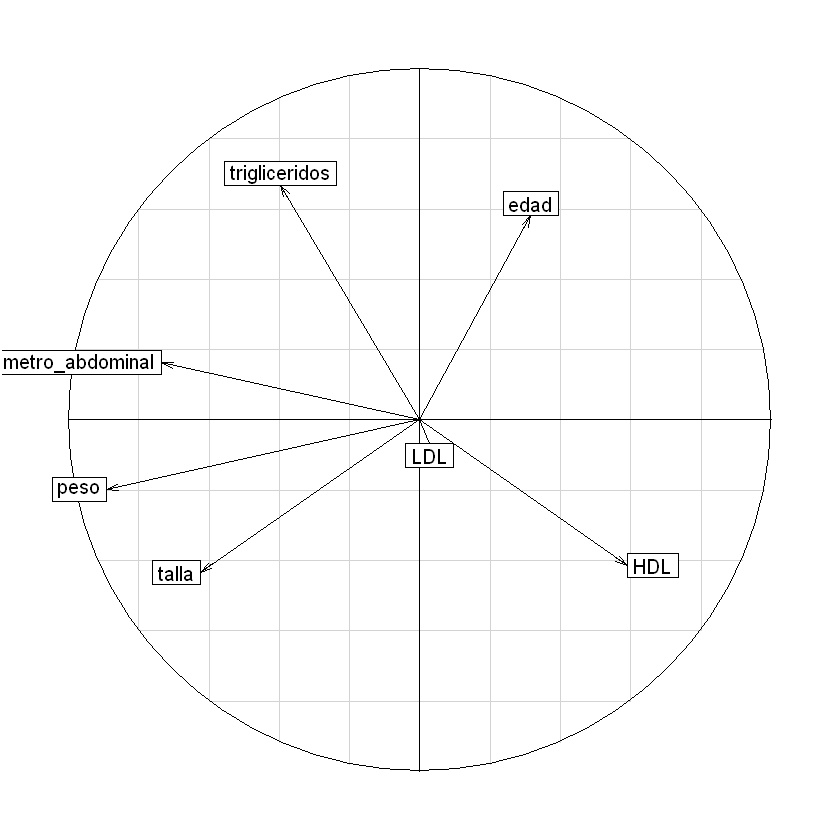

In [23]:
print("Correlaciones de las variables suplementarias")
s.corcircle(acp$co, xax = 1, yax = 2)

[1] "Correlaciones de las variables suplementarias"


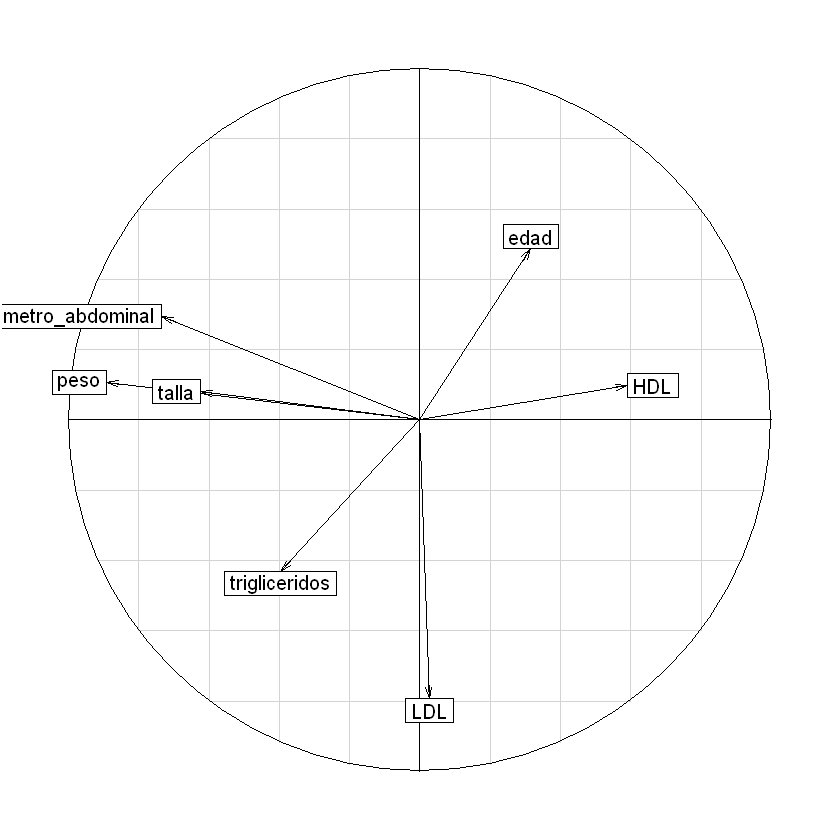

In [25]:
print("Correlaciones de las variables suplementarias")
s.corcircle(acp$co, xax = 1, yax = 3)

In [27]:
sup <- supqual(acp, data[, c("diabetes")])

kable(cbind(wcat = sup$wcat, d2 = sup$dis2, sup$coor), digits = 3)



|   |  wcat|    d2|  Axis1|  Axis2|  Axis3|  Axis4|  Axis5|  Axis6|  Axis7|
|:--|-----:|-----:|------:|------:|------:|------:|------:|------:|------:|
|X0 | 0.834| 0.003|  0.033| -0.034| -0.011|  0.002| -0.011|  0.004| -0.003|
|X1 | 0.166| 0.064| -0.168|  0.169|  0.055| -0.009|  0.054| -0.023|  0.015|

[1] "Representacion de Diabetes en los ejes principales"


        Axis2       Axis3
0 -0.03361267 -0.01101993
1  0.16907423  0.05543109


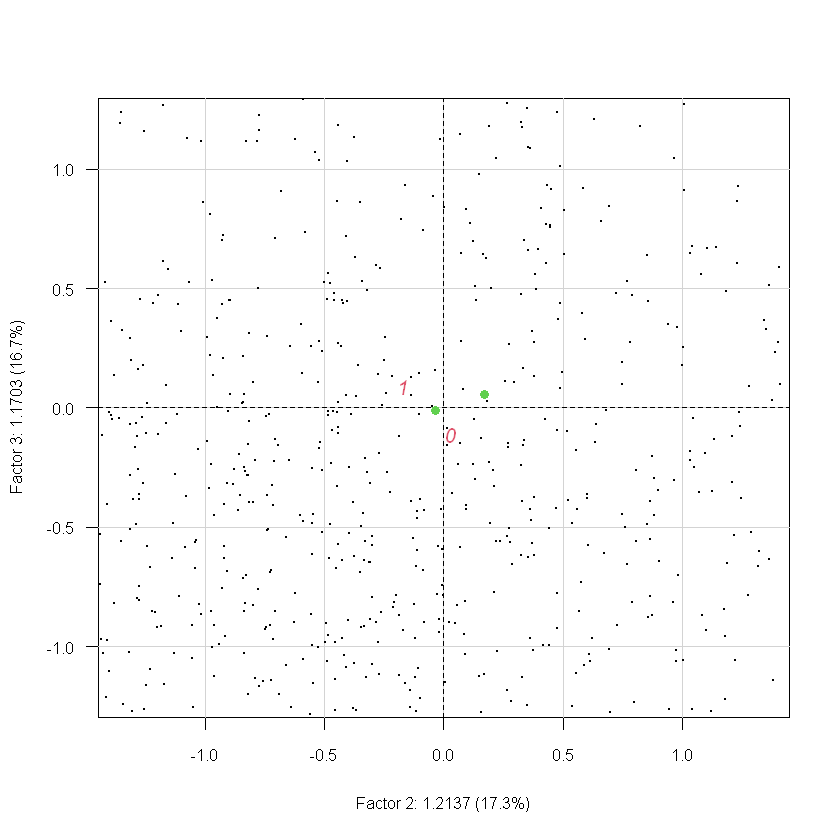

In [31]:
print("Representacion de Diabetes en los ejes principales")
ejes <- c(2, 3)
plot(acp[1:1000, ], ex = ejes[1], ey = ejes[2],
     Tcol = FALSE, ucal = 100, cex.row = 0.01,
     ylim = c(-1, 1), xlim = c(-1, 1))
print(sup$coor[, ejes])
points(sup$coor[, ejes], col = 3, pch = 16)
text(sup$coor, labels = rownames(sup$coor),
     col = 2, pos = 1, font = 3)

[1] "Agrupamiento basado en Diabetes para los ejes principales 2 y 3"


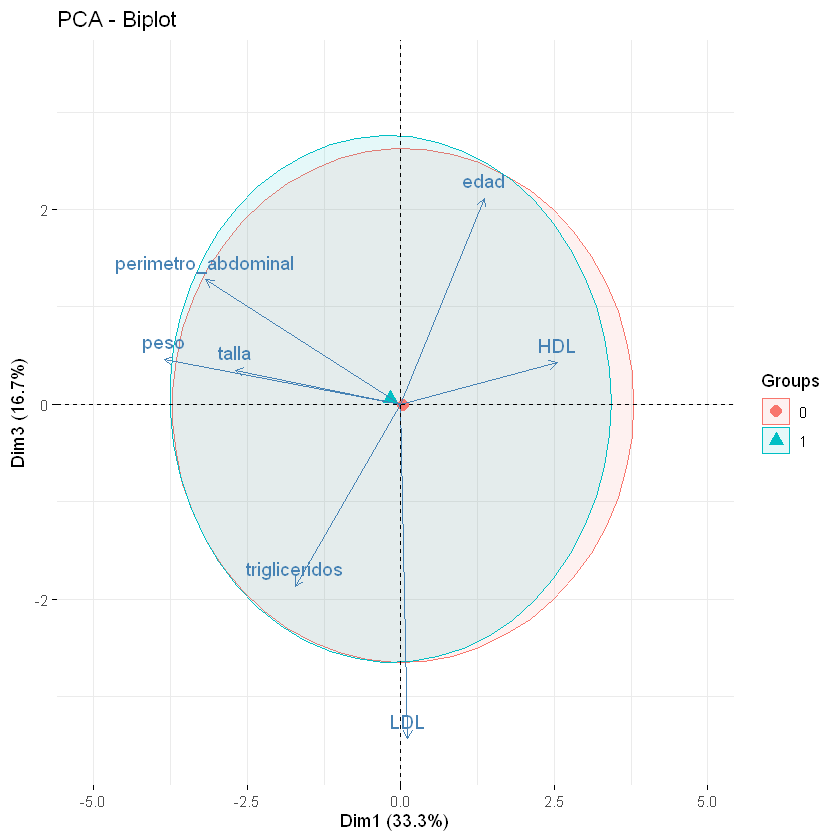

In [34]:
print("Agrupamiento basado en Diabetes para los ejes principales 2 y 3")
fviz_pca_biplot(acp, axes = c(1, 3), label = "var",
                habillage = data$diabetes,
                alpha.ind = 0,
                col.circle = "green",
                addEllipses = TRUE)

## ACM